In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline
import jax
import jax.numpy as np
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions
from nsec.samplers import ScoreHamiltonianMonteCarlo
from nsec.datasets.two_moons import get_two_moons
from nsec.annealed_sampling import TemperedMC

Populating the interactive namespace from numpy and matplotlib


In [2]:
dist = get_two_moons(0.02)

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
from tensorflow_probability.python.internal.backend import jax as tf

dtype = tf.float32

# target = tfd.MixtureSameFamily(
#     mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
#     components_distribution=tfd.MultivariateNormalDiag(
#         loc=[[-1., -1], [1., 1.]],
#         scale_identity_multiplier=[0.1, 0.1]))

target = dist

inverse_temperatures = 0.2**tf.range(4, dtype=dtype)

# step_size must broadcast with all batch and event dimensions of target.
# Here, this means it must broadcast with:
#  [len(inverse_temperatures)] + target.event_shape
step_size = 0.01 / tf.reshape(tf.sqrt(inverse_temperatures), shape=(4, 1))

In [4]:
inverse_temperatures

DeviceArray([1.   , 0.2  , 0.04 , 0.008], dtype=float32)

In [12]:
step_size

DeviceArray([[0.01      ],
             [0.02236068],
             [0.05      ],
             [0.11180339]], dtype=float32)

In [13]:
rng_key = jax.random.PRNGKey(seed=0)

In [14]:
def make_kernel_fn(target_log_prob_fn):
  return tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      step_size=step_size, num_leapfrog_steps=3)

remc = ReplicaExchangeMC(
    target_log_prob_fn=target.log_prob,
    inverse_temperatures=inverse_temperatures,
    make_kernel_fn=make_kernel_fn)

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=10000,
    # Start near the [1, 1] mode.  Standard HMC would get stuck there.
    current_state=0.5*tf.zeros(2, dtype=dtype),
    kernel=remc,
    trace_fn=lambda _, pkr: pkr.pre_swap_replica_results.is_accepted,
    num_burnin_steps=500, seed=rng_key)

In [15]:
[len(where(is_accepted[:,i])[0]) for i in range(4)]

[8859, 8575, 8477, 9364]

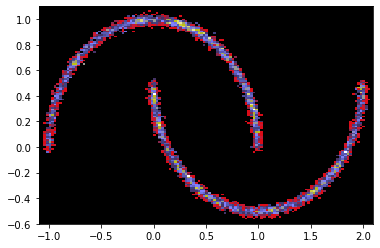

In [16]:
hist2d(samples[:,0],samples[:,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

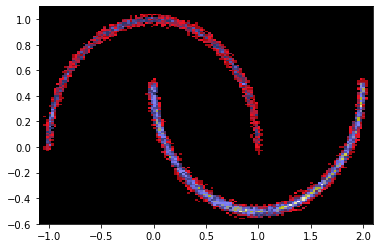

In [47]:
hist2d(samples[:,0],samples[:,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

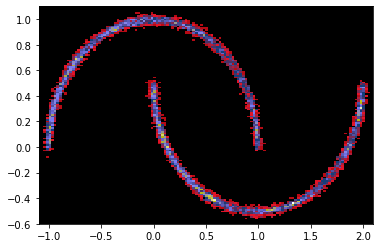

In [9]:
hist2d(samples[:,0],samples[:,1],128,
       range=[[-1.1,2.1],[-0.6,1.1]],cmap='gist_stern');

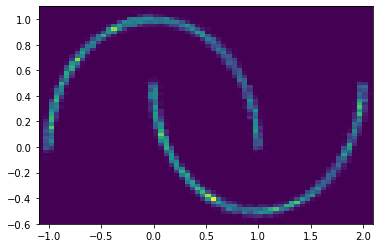

In [15]:
hist2d(samples[:,0],samples[:,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [ ]:
def make_replica_target_log_prob_fn(log_prob_fn, inverse_temp):
    def fn(x):
        y = log_prob_fn(x) * inverse_temp
    return fn

In [10]:
def make_kernel_fn(target_log_prob_fn, target_score_fn):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=step_size, 
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

In [11]:
remc = ReplicaExchangeMC(
    target_score_fn=score_fn,
    inverse_temperatures=sigmas,
    make_kernel_fn=make_kernel_fn,
    num_delta_logp_steps=32)

In [12]:
def trace_swaps(unused_state, results):
  return (results.is_swap_proposed_adjacent,
          results.is_swap_accepted_adjacent)

In [13]:
num_results = int(1e4)
num_burnin_steps = int(1e2)

In [14]:
samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=np.zeros([1,2]),
        kernel=remc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: pkr.pre_swap_replica_results.is_accepted,
        seed=jax.random.PRNGKey(0))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [15]:
[len(where(trace[:,i,0])[0]) for i in range(4)]

[9268, 9735, 9923, 9985]

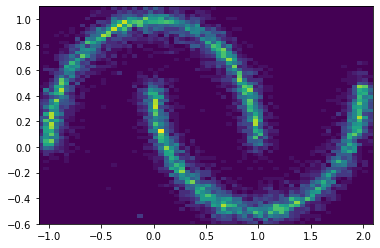

In [16]:
hist2d(samples[:,0,0],samples[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

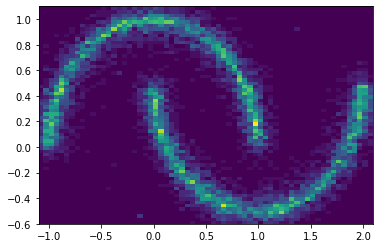

In [17]:
hist2d(samples[:,0,0],samples[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [32]:
dist_target=get_two_moons(sigmas[0]+0.02)

In [33]:
samps = dist_target.sample(10000, seed=jax.random.PRNGKey(0))

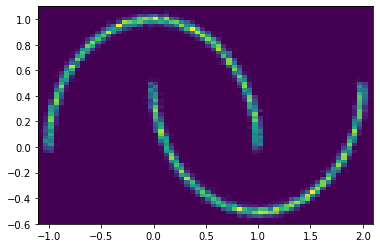

In [34]:
hist2d(samps[:,0],samps[:,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [24]:
# And just to compare, what would have happened if we only ran a normal
# HMC in the same conditions
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=dist_target.log_prob,
    num_leapfrog_steps=3,
    step_size=0.0125)

In [25]:
samples_hmc, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=np.zeros([1,2]),
      kernel=hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(0))

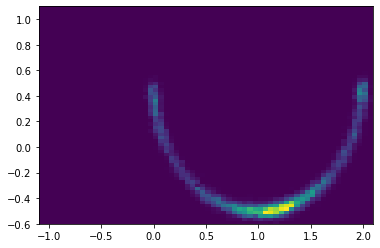

In [26]:
hist2d(samples_hmc[:,0,0],samples_hmc[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);